In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.stats as stats
import scipy.special
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from statsmodels.distributions.empirical_distribution import ECDF

#import testing
import sys
sys.path.append("../")
import vuong_tests

In [2]:
num_true = 10
num_bidders1 = 10
num_bidders2 = 2
mu = 3
sigma = 2

def gen_data(values=stats.logistic(loc=mu, scale=sigma)):
    nobs = 1000
    
    #parameters
    
    
    min_bids =num_true
    max_bids =num_true
    
    bid_types = range(min_bids,max_bids+1)
    prob_type = [1/len(bid_types)]*len(bid_types)
    bidders = np.random.choice(bid_types, nobs, p=prob_type)
    bidders = np.sort(bidders)
    bids = []
    for i in bid_types:
        #count number of obs
        num_i = sum(i == bidders)
        bids_i = values.rvs(size=(num_i,i))
        bids_i =  np.sort(bids_i, axis=1)
        bids_i =  bids_i[:,-2]
        bids = np.concatenate((bids, bids_i))
    
    #draw bids
    return bids,bidders,nobs


values_distr =stats.logistic(loc=mu, scale=sigma)
bids,i,nobs = gen_data(values_distr)
print(bids.shape)
print(bids[i == num_true].mean())

(1000,)
6.41530806233285


In [9]:
class Auction(GenericLikelihoodModel):
    
    def __init__(self, *args, values_distr=stats.logistic, **kwargs):
        super(Auction,self).__init__(*args,**kwargs)
        self.values_distr = values_distr
        
    
    def loglikeobs(self, params):
        bids = self.endog
        i = self.exog[:,0]
        cdf = self.values_distr.cdf(bids,loc=params[0],scale=max(params[1],1e-5))
        pdf = self.values_distr.pdf(bids,loc=params[0],scale=max(params[1],1e-5))
        factorial = scipy.special.factorial(i)/scipy.special.factorial(i-2)  
        
        order_cdf = factorial*pdf*cdf**(i-2)*(1-cdf) #np.log(i) + np.log(cdf) + (i-1)*np.log((1-cdf)) #second highest order statistic
        return np.log(order_cdf)

np.random.seed()
yn,xn,nobs = gen_data(stats.logistic(loc=mu, scale=sigma))
model = Auction(yn,xn)
model_fit = model.fit(start_params=[mu,sigma],disp=False)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               Auction Results                                
==============================================================================
Dep. Variable:                      y   Log-Likelihood:                -1944.5
Model:                        Auction   AIC:                             3891.
Method:            Maximum Likelihood   BIC:                             3896.
Date:                Thu, 24 Dec 2020                                         
Time:                        21:53:46                                         
No. Observations:                1000                                         
Df Residuals:                     999                                         
Df Model:                           0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1228      0.081     38.400      0.000       2.963       3.282
par0           1.9890      0.047     41.885      0.000       1.896       2.082
==============================================================================
"""

In [10]:
def compute_llr(yn,xn):
    
    #fit normal values
    model1 = Auction(yn,xn*num_bidders1/num_true)
    model1_fit = model1.fit(start_params=[mu,sigma],disp=False)
    ll1 = model1.loglikeobs(model1_fit.params)
    
    #fit logistic values
    model2 = Auction(yn,xn*num_bidders2/num_true)
    model2_fit = model2.fit(start_params=[mu,sigma],disp=False)
    ll2 = model2.loglikeobs(model2_fit.params)
    
    llr = ll1.sum() - ll2.sum()
    omega2 = (ll1- ll2).var()
    return llr,np.sqrt(omega2)

yn,xn,nobs = gen_data()
print(compute_llr(yn,xn))

(54.95080261569319, 0.31251727864699513)


In [11]:
#compute llr without actually bootstrapping
avg_llr =0 
avg_omega = 0
n =100
for i in range(n):
    yn,xn,nobs = gen_data()
    res1, res2 = compute_llr(yn,xn)
    avg_llr = avg_llr + res1
    avg_omega = avg_omega + res2
print(avg_llr/n ,avg_omega/n )

57.17252428323274 0.3027835721897329


1
1


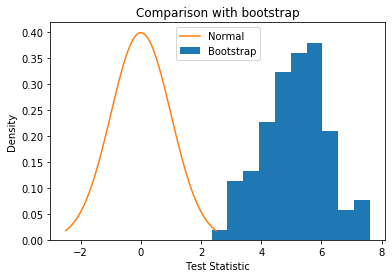

In [12]:
yn,xn,nobs = gen_data()
print(vuong_tests.bootstrap_test(yn,xn,nobs,compute_llr,hist=True))
print(vuong_tests.regular_test(yn,xn,nobs,compute_llr,hist=True))

plt.title("Comparison with bootstrap")
plt.xlabel("Test Statistic")
plt.ylabel("Density")
plt.legend()
plt.savefig('../figs/bootstrap_compare_bidders')
plt.show()

In [13]:
reg,boot,llr, omega = vuong_tests.monte_carlo(100,gen_data,compute_llr)
print("reg: %s, boot: %s, llr:%s, omega:%s"%(reg,boot,llr, omega))

/home/erichschulman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


reg: [0. 1. 0.], boot: [0. 1. 0.], llr:56.33227718835717, omega:0.2984294935913353


In [14]:
def setup_shi(yn,xn):
    model1 = Auction(yn,xn*num_bidders1/num_true)
    model1_fit = model1.fit(start_params=[mu,sigma],disp=False)
    ll1 = model1.loglikeobs(model1_fit.params)
    grad1 =  model1.score_obs(model1_fit.params)    
    hess1 = model1.hessian(model1_fit.params)
    
    #fit logistic values
    model2 = Auction(yn,xn*num_bidders2/num_true)
    model2_fit = model2.fit(start_params=[mu,sigma],disp=False)
    ll2 = model2.loglikeobs(model2_fit.params)
    grad2 =  model2.score_obs(model2_fit.params)    
    hess2 = model2.hessian(model2_fit.params)
    
    return ll1,grad1,hess1,ll2,2, grad2,hess2,2

yn,xn,nobs = gen_data()
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)

In [15]:
shi_result = vuong_tests.monte_carlo_shi(100,setup_shi,gen_data)
print(shi_result)

[0.01 0.99 0.  ]
